In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime as dt
import tensorflow_hub as hub

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import helper_functions as hf

--2022-07-26 14:07:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-26 14:07:32 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 2022.06.25 - Transfer Learning

### Introdcution
- utilize the pre-trained model with existing NN arch. which is a approach to the problem that is **similar** to our's
- can use less data to get good model performance
- reduce time/computing cost from the scratch
- ImageNet is database that contains a very huge volume of images

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-26 14:07:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   279MB/s    in 0.6s    

2022-07-26 14:07:37 (279 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath,directory,images in os.walk("./10_food_classes_10_percent/train"):
  print(f"there are {len(directory)} directory and {len(images)} images in {dirpath}")

there are 10 directory and 0 images in ./10_food_classes_10_percent/train
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/steak
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/ice_cream
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/pizza
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/chicken_wings
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/grilled_salmon
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/fried_rice
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/sushi
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/chicken_curry
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/ramen
there are 0 directory and 75 images in ./10_food_classes_10_percent/train/hamburger


In [ ]:
# Capital variable is usually viewed as hyper parameter of the model 
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "./10_food_classes_10_percent/train"
test_dir = "./10_food_classes_10_percent/test"

train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

print("Training Images:")
train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size=IMG_SIZE,
                                                class_mode="categorical",
                                                batch_size=BATCH_SIZE)
print("Testing Images:")
test_data = test_data_gen.flow_from_directory(test_dir,
                                                target_size=IMG_SIZE,
                                                class_mode="categorical",
                                                batch_size=BATCH_SIZE)

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


### Callbacks - Tensorboard
- Utility:
  - Settings up the callback. will be performed during or after the model training
- Different kinds of Callbacks:
  - Tensorboard
    - Tracking experiments. tracking the loss/metrics during each epochs
  - ModelCheckpoint
    - for model saving
  - Stopping a model from training (before it occur overfitting or train too long)
    - EarlyStopping Callback
  - others: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [ ]:
### 1. Set up Tracking experiments
def create_tensorboard_callback(dir_name,experiment_name):
  dir = dir_name+"/"+experiment_name+"/" + dt.datetime.now().strftime("%Y%m%d_%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = dir)
  print(f"Generate Folder {dir} for tracking exp")
  return tensorboard_callback

### Tensorflow hub
- the place that contains multiple pre-trained Machine learning Model for different kind of problems
- buut how to find which is the best model to fit our own problem domain
  - go to paper with codes, to find the paper/codes that resolve the problem which is similar to us
  - then go to tensorflow hub to find the correpongin model
  - finally choose efficientnet/b0/feature-vector
    - the number behind the b is larger, then the model will be more complicated
- the input shape of hub model is not fixed. It can be dynamic based on the images that belong to your problem domain

In [ ]:
len(train_data.class_indices)

{'chicken_curry': 0,
 'chicken_wings': 1,
 'fried_rice': 2,
 'grilled_salmon': 3,
 'hamburger': 4,
 'ice_cream': 5,
 'pizza': 6,
 'ramen': 7,
 'steak': 8,
 'sushi': 9}

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def plot_loss_curve(history):
  loss = history.history["loss"] # train loss
  val_loss = history.history["val_loss"] # val loss
  accuracy = history.history["accuracy"] # train accuracy
  val_accuracy = history.history["val_accuracy"] # test accuracy

  epochs = range(len(loss))
  epochs = list(map(lambda x:int(x+1),epochs))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()
  plt.show()

  plt.plot(epochs,accuracy,label="training_acc")
  plt.plot(epochs,val_accuracy,label="validation_acc")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()

In [ ]:
def create_model(model_url,num_classes=10):
  global IMG_SIZE
  """
  take a tensorflow hub model to create keras Sequential Model
  Args:
    model_url (str): model url from tensorflow hub
    num_classes: the number of target classes default is 10
  Returns:
    Return hub model with num_classes neurons in the output layer
  """
  # like the combine all layers from the hub model into one composite layer
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url,
                   trainable=False, # it meas this layer won't have any trainable params 
                  # if switch to True, then might need to more time to train this pre-trained model
                   name="feature_extraction_layer",
                   input_shape = IMG_SIZE+(3,)),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax',name="output_layer")
  ])

  return model


In [ ]:
resnet_model = create_model(resnet_url)
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

tb_callbacks = create_tensorboard_callback(dir_name="tensorflow_hub",
                                           experiment_name="resnet50v2")

history = resnet_model.fit(train_data,
          epochs = 5,
           steps_per_epoch = len(train_data),
           validation_data = test_data,
           validation_steps = len(test_data),
           callbacks = [tb_callbacks])

Generate Folder {dir} for tracking exp
Epoch 1/5
24/24 [==============================] - 19s 695ms/step - loss: 1.8112 - accuracy: 0.3987 - val_loss: 1.1412 - val_accuracy: 0.6440
Epoch 2/5
24/24 [==============================] - 16s 677ms/step - loss: 0.8683 - accuracy: 0.7453 - val_loss: 0.8489 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.5987 - accuracy: 0.8333 - val_loss: 0.7583 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.4518 - accuracy: 0.8907 - val_loss: 0.7031 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3736 - accuracy: 0.9173 - val_loss: 0.6827 - val_accuracy: 0.7784


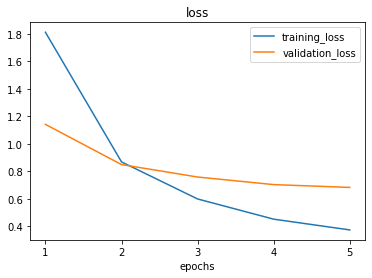

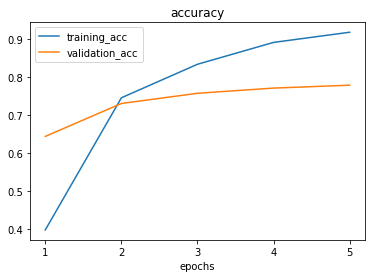

In [ ]:
plot_loss_curve(history)

In [ ]:
eff_model = create_model(efficientnet_url)
eff_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
eff_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

tb_eff_callbacks = create_tensorboard_callback(dir_name="tensorflow_hub",
                                           experiment_name="efficientnet_b0")

eff_history = resnet_model.fit(train_data,
          epochs = 5,
           steps_per_epoch = len(train_data),
           validation_data = test_data,
           validation_steps = len(test_data),
           callbacks = [tb_eff_callbacks])

Generate Folder tensorflow_hub/efficientnet_b0/20220625_115925 for tracking exp
Epoch 1/5
24/24 [==============================] - 17s 679ms/step - loss: 0.3041 - accuracy: 0.9440 - val_loss: 0.6577 - val_accuracy: 0.7848
Epoch 2/5
24/24 [==============================] - 16s 671ms/step - loss: 0.2504 - accuracy: 0.9627 - val_loss: 0.6477 - val_accuracy: 0.7852
Epoch 3/5
24/24 [==============================] - 16s 706ms/step - loss: 0.2114 - accuracy: 0.9680 - val_loss: 0.6534 - val_accuracy: 0.7808
Epoch 4/5
24/24 [==============================] - 16s 670ms/step - loss: 0.1820 - accuracy: 0.9720 - val_loss: 0.6300 - val_accuracy: 0.7916
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.1567 - accuracy: 0.9840 - val_loss: 0.6398 - val_accuracy: 0.7896


In [ ]:
len(eff_model.layers[0].weights), len(resnet_model.layers[0].weights)

(309, 270)

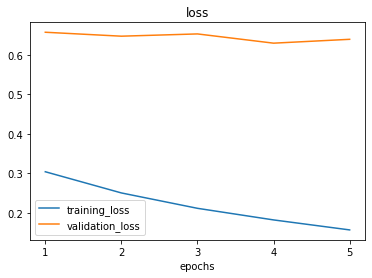

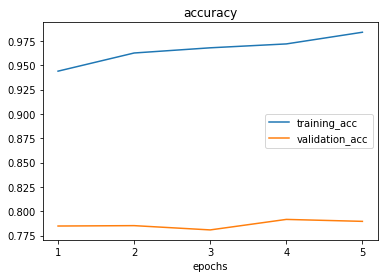

In [ ]:
plot_loss_curve(eff_history)

### Different kinds -Transfer Learning
- As is Transfer Learning
  - no changes on the existing model including the output layer
- Feature Extraction
  - use pre-learned model and change the final layer to fit your own problem domain like 1000classess -> your own 10 layers
- Fine-Tuning
  - use pre-learned model and change some or all you need on the existing model and add on own hidden layer if your need
  - need more data than Feature extraction

### View the Tensorboard.dev
- the experiments uploaded to the Tensorboard.dev will be publicly published.
  - tensorrboard.dev provide visualized toolkit to visualize your experiments

In [ ]:
!tensorboard dev upload --logdir "./tensorflow_hub" \
--name "EfficientnetB0 vs resnet50v2" \ye
--description "Comparing the model performance using two kinds of model "


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=wxwreHoGR0LU9VsiKSBgjPlRGuQtu7&prompt=consent&access_type=offl

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/AKfdJv6aQ4CWNpKflLiNGw/
	Name                 EfficientnetB0 vs resnet50v2
	Description          Comparing the model performance using two kinds of model 
	Id                   AKfdJv6aQ4CWNpKflLiNGw
	Created              2022-06-25 12:23:30 (7 minutes ago)
	Updated              2022-06-25 12:23:36 (7 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  12575200
Total: 1 experiment(s)


### Exercise with Tensorflow Hub

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2022-06-25 12:41:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.192.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   227MB/s    in 0.5s    

2022-06-25 12:41:04 (227 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath,directory,images in os.walk("./pizza_steak"):
  print(f"{len(directory)} directories, {len(images)} images in {dirpath}")

2 directories, 0 images in ./pizza_steak
2 directories, 0 images in ./pizza_steak/test
0 directories, 250 images in ./pizza_steak/test/steak
0 directories, 250 images in ./pizza_steak/test/pizza
2 directories, 0 images in ./pizza_steak/train
0 directories, 750 images in ./pizza_steak/train/steak
0 directories, 750 images in ./pizza_steak/train/pizza


In [ ]:
# reversed the data cuz we are using tensorflow hub, no need too much training data
train_dir = "./pizza_steak/test"
test_dir = "./pizza_steak/train"

train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                target_size=(224,224),
                                                class_mode="binary")

test_data = test_data_gen.flow_from_directory(test_dir,
                                                batch_size=32,
                                                target_size=(224,224),
                                                class_mode="binary")



Found 500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False,
                   input_shape=(224,224,3),
                   name="feature_extraction_layer"),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])



m.compile(loss = tf.keras.losses.BinaryCrossentropy(),
          optimizer = tf.keras.optimizers.Adam(),
          metrics = ["accuracy"])

history = m.fit(train_data,
                epochs=10,
                steps_per_epoch=len(train_data),
                validation_data=test_data,
                validation_steps=len(test_data),
                callbacks = [create_tensorboard_callback("tensorflow_hub_exe","efficientnet_b0")])

Generate Folder tensorflow_hub_exe/efficientnet_b0/20220625_125149 for tracking exp
Epoch 1/10
16/16 [==============================] - 19s 675ms/step - loss: 0.5462 - accuracy: 0.7540 - val_loss: 0.3701 - val_accuracy: 0.9140
Epoch 2/10
16/16 [==============================] - 9s 611ms/step - loss: 0.2427 - accuracy: 0.9820 - val_loss: 0.2299 - val_accuracy: 0.9467
Epoch 3/10
16/16 [==============================] - 9s 612ms/step - loss: 0.1440 - accuracy: 0.9900 - val_loss: 0.1776 - val_accuracy: 0.9540
Epoch 4/10
16/16 [==============================] - 9s 614ms/step - loss: 0.1032 - accuracy: 0.9900 - val_loss: 0.1517 - val_accuracy: 0.9573
Epoch 5/10
16/16 [==============================] - 10s 667ms/step - loss: 0.0819 - accuracy: 0.9920 - val_loss: 0.1367 - val_accuracy: 0.9607
Epoch 6/10
16/16 [==============================] - 9s 617ms/step - loss: 0.0681 - accuracy: 0.9920 - val_loss: 0.1253 - val_accuracy: 0.9640
Epoch 7/10
16/16 [==============================] - 9s 613ms/s

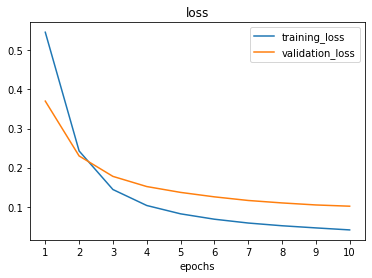

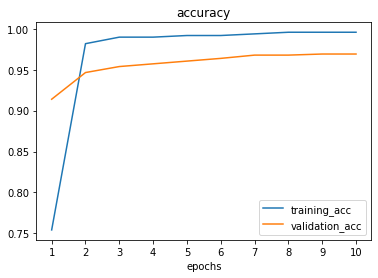

In [ ]:
plot_loss_curve(history)

In [ ]:
m.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
!tensorboard dev upload --logdir "tensorflow_hub_exe" --name "exercise" --description "exe"

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/5HeDPQwUQoec0Nb0vip9qg/

[2022-06-25T12:55:07] Started scanning logdir.
[2022-06-25T12:55:09] Total uploaded: 90 scalars, 0 tensors, 2 binary objects (7.8 MB)


Done. View your TensorBoard at https://tensorboard.dev/experiment/5HeDPQwUQoec0Nb0vip9qg/
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/uploader/uploader_subcommand.py", line 482, in execute
    uploader.start_uploading()
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/uploader/uploader.py", line 212, in start_uploading
    self._logdir_poll_rate_limiter.tick()
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/uploader/util.py", line 42, in tick
    self._time.sleep(wait_secs)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

In [ ]:
# show how many exp has been uploaded to the Tensorboard
!tensorboard dev list

https://tensorboard.dev/experiment/5HeDPQwUQoec0Nb0vip9qg/
	Name                 exercise
	Description          exe
	Id                   5HeDPQwUQoec0Nb0vip9qg
	Created              2022-06-25 12:55:07 (5 minutes ago)
	Updated              2022-06-25 12:55:09 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  8151421
https://tensorboard.dev/experiment/AKfdJv6aQ4CWNpKflLiNGw/
	Name                 EfficientnetB0 vs resnet50v2
	Description          Comparing the model performance using two kinds of model 
	Id                   AKfdJv6aQ4CWNpKflLiNGw
	Created              2022-06-25 12:23:30 (36 minutes ago)
	Updated              2022-06-25 12:23:36 (36 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  12575200
Total: 2 experiment(s)


## Review

In [6]:
### Exercise  multi-cllass
# Capital variable is usually viewed as hyper parameter of the model 
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "./10_food_classes_10_percent/train"
test_dir = "./10_food_classes_10_percent/test"

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2)

test_data_gen = ImageDataGenerator(rescale=1./255)

print("Training Images:")
train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size=IMG_SIZE,
                                                shuffle=True,
                                                class_mode="categorical",
                                                batch_size=BATCH_SIZE)
print("Testing Images:")
test_data = test_data_gen.flow_from_directory(test_dir,
                                                target_size=IMG_SIZE,
                                                class_mode="categorical",
                                                batch_size=BATCH_SIZE)

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


In [8]:
import tensorflow_hub as hub

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(224,224,3)))
model.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

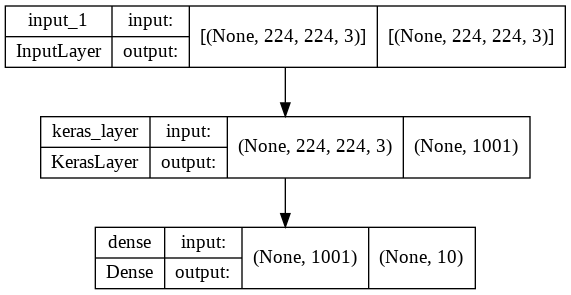

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [14]:
history = model.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 2.5288 - accuracy: 0.3067 - val_loss: 1.3826 - val_accuracy: 0.5488
Epoch 2/5
24/24 [==============================] - 23s 977ms/step - loss: 1.2752 - accuracy: 0.5947 - val_loss: 1.0104 - val_accuracy: 0.6632
Epoch 3/5
24/24 [==============================] - 23s 980ms/step - loss: 0.9588 - accuracy: 0.6813 - val_loss: 0.8764 - val_accuracy: 0.7124
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.7680 - accuracy: 0.7627 - val_loss: 0.8087 - val_accuracy: 0.7340
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.7279 - accuracy: 0.7507 - val_loss: 0.7899 - val_accuracy: 0.7496


In [15]:
model.evaluate(test_data)

79/79 [==============================] - 12s 151ms/step - loss: 0.7899 - accuracy: 0.7496


[0.7899360656738281, 0.7495999932289124]

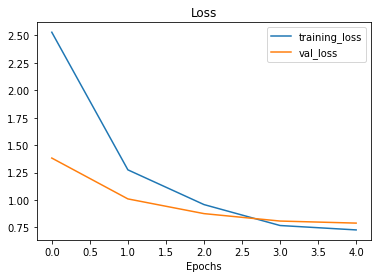

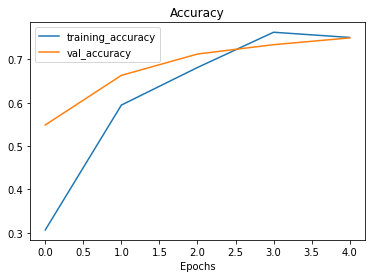

In [16]:
hf.plot_loss_curves(history)

In [ ]:
### Binary Classification

In [17]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-26 14:19:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   120MB/s    in 0.9s    

2022-07-26 14:19:04 (120 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [42]:
### Exercise  multi-cllass
# Capital variable is usually viewed as hyper parameter of the model 
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "./pizza_steak/train"
test_dir = "./pizza_steak/test"

train_data_gen = ImageDataGenerator(rescale=1/255.)

test_data_gen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size=IMG_SIZE,
                                                shuffle=True,
                                                class_mode="binary",
                                                batch_size=BATCH_SIZE)
print("Testing Images:")
test_data = test_data_gen.flow_from_directory(test_dir,
                                                target_size=IMG_SIZE,
                                                class_mode="binary",
                                                batch_size=BATCH_SIZE)

Training Images:
Found 1500 images belonging to 2 classes.
Testing Images:
Found 500 images belonging to 2 classes.


In [43]:
ef_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [68]:
#tf.random.set_seed(42)
model_n = tf.keras.models.Sequential()
model_n.add(tf.keras.layers.Input(shape=(224,224,3)))
model_n.add(hub.KerasLayer(ef_url))
model_n.add(tf.keras.layers.Dense(1,activation="sigmoid"))

model_n.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [69]:
#plot_model(model,show_shapes=True)

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [58]:
tb = tf.keras.callbacks.TensorBoard("./binary/efficientnetb0")

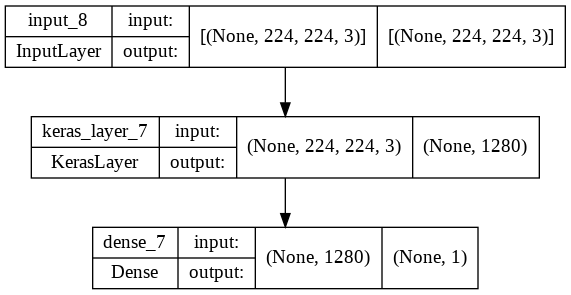

In [57]:
plot_model(model,show_shapes=True)

In [70]:
tb = tf.keras.callbacks.TensorBoard("./binary/efficientnetb0")
history = model_n.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data),
          callbacks=[tb])

Epoch 1/5
47/47 [==============================] - 18s 220ms/step - loss: 0.3836 - accuracy: 0.8460 - val_loss: 0.1339 - val_accuracy: 0.9920
Epoch 2/5
47/47 [==============================] - 9s 199ms/step - loss: 0.1400 - accuracy: 0.9673 - val_loss: 0.0725 - val_accuracy: 0.9940
Epoch 3/5
47/47 [==============================] - 9s 202ms/step - loss: 0.0992 - accuracy: 0.9773 - val_loss: 0.0519 - val_accuracy: 0.9960
Epoch 4/5
47/47 [==============================] - 9s 199ms/step - loss: 0.0800 - accuracy: 0.9787 - val_loss: 0.0421 - val_accuracy: 0.9960
Epoch 5/5
47/47 [==============================] - 9s 198ms/step - loss: 0.0687 - accuracy: 0.9827 - val_loss: 0.0361 - val_accuracy: 0.9960


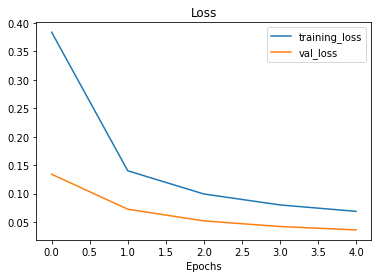

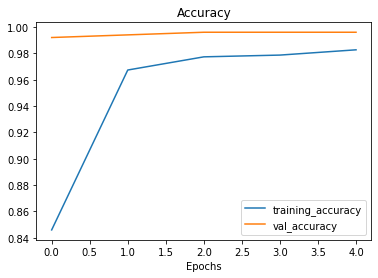

In [71]:
hf.plot_loss_curves(history)

In [72]:
model_n.save("pre-trained.h5")

In [75]:
loaded_model = tf.keras.models.load_model(
    "pre-trained.h5",
    custom_objects = {
        "KerasLayer": hub.KerasLayer
    }
)

In [76]:
loaded_model.evaluate(test_data)

16/16 [==============================] - 3s 144ms/step - loss: 0.0361 - accuracy: 0.9960


[0.036072272807359695, 0.9959999918937683]

In [74]:
from google.colab import files
files.download("pre-trained.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>